<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/05-many-two-state-systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/05-many-two-state-systems.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 5 - Many two state systems

> TODO: Intro

In [1]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import Image, Math
import gif
import numpy as np
import pandas as pd
from qutip import *
from qutip.piqs import *
from qutip.cy.piqs import j_min, j_vals, m_vals
import warnings
warnings.filterwarnings('ignore')
from itertools import product
import os
from fractions import Fraction

# Functions created in 04 tutorial

from libs.helper_05_tutorial import *

def prettify_states(states, mm_list):
    pretty_states = np.zeros([len(mm_list),len(states)], dtype="object")
    
    for j, state in enumerate(states):
        x = []
        for i, val in enumerate(state):
            pretty_states[i,j] = f"{val[0,0]:.1f}"
        
    return pd.DataFrame(data=pretty_states, index=mm_list)

As soon as we start adding more than one TSS things get quite complicated. In order to give us an intuition for how such systems behave, we will take inspiration from Tutorials 1 and 2.




Let's start simple and look at 2 TSS. We can describe this system by the different possible combinations of the + and -, namely:
- |+,+>
- |+,->
- |-,+>
- |-,->

So, 2 TSS is actually a 4 state system. Mathematically these 4 states can be represented as vectors of length 4 using the following basis:

$$
|+, +> = \begin{bmatrix}
 1   \\
 0   \\
 0   \\
 0   \\
 \end{bmatrix}, 
|+, -> = \begin{bmatrix}
 0   \\
 1   \\
 0   \\
 0   \\
\end{bmatrix}, 
|-, +> = \begin{bmatrix}
 0   \\
 0   \\
 1   \\
 0   \\
\end{bmatrix}, 
|-, -> = \begin{bmatrix}
 0   \\
 0   \\
 0   \\
 1   \\
\end{bmatrix}
$$

How to we create these states in QuTiP?

In [Tutorial 3](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/03-a-two-state-system-in-a-quantised-field.ipynb#3.5---Describing-coupled-systems-in-QuTiP) we learnt to describe such states| by using the tensor product. For example, we would create the |+,-> state by doing:

In [2]:
tensor(basis(2,0), basis(2,1))

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]

and we can keep track of which basis states corresponds to which row by using the `product` function that we introduced in the previous tutorial. Specifically:

In [3]:
possible_ms = ["+","-"]
mm_list = [m for m in product(possible_ms, possible_ms)]
mm_list

[('+', '+'), ('+', '-'), ('-', '+'), ('-', '-')]

So, the row number 1 of the state vector refers to the basis state:

In [4]:
mm_list[1]

('+', '-')

How does such a system behave?

## Independent TSS

In [tutorial 1](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/01-an-isolated-two-state-system.ipynb#1---An-isolated-two-state-system), we motivated that a single isolated TSS, whose states have the same energy $E_0$ and are coupled with some strength $A$, can be described by a Hamiltonian of the form:

$$
H = E_0 I - A \sigma_x
$$

where we now know that we can set $E_0=0$ (without loss of generality) leaving us with:

$$
H = - A \sigma_x
$$

We found that (due to the coupling) the |+> and |-> basis states were not actually states of constant energy (i.e. stationary states). This gave rise to Rabi oscillations in the probabilities.

Let's refresh our memory and re-simulate this case.

Before we do this, we will make a minor adjustment to the Hamiltonian.

You may recall that there are mathematical similarities between a TSS and a spin $1/2$ particle. When considering many TSS, we will find it invaluable to refer to well known spin results, such as conservation of angular momentum, to help us solve problems. In light of this, we will introduce a factor of $1/2$ into the Hamiltonian:

$$
H = - A \frac{1}{2}\sigma_{x}
$$

so that we can rewrite the Hamiltonian in terms of spin operators, (denoted by $S$), for a [spin $1/2$ particle](https://en.wikipedia.org/wiki/Spin-%C2%BD#Observables), i.e.

$$
H = - A S_{x}
$$


In [35]:
A=0.1
H = -A*sigmax()/2

times = np.linspace(0.0, 99.0, 1000) 

psi0=basis(2,0)

P, psi = simulate(H, psi0, times)

In [36]:
bra_labels, ket_labels = make_braket_labels(["+","-"])

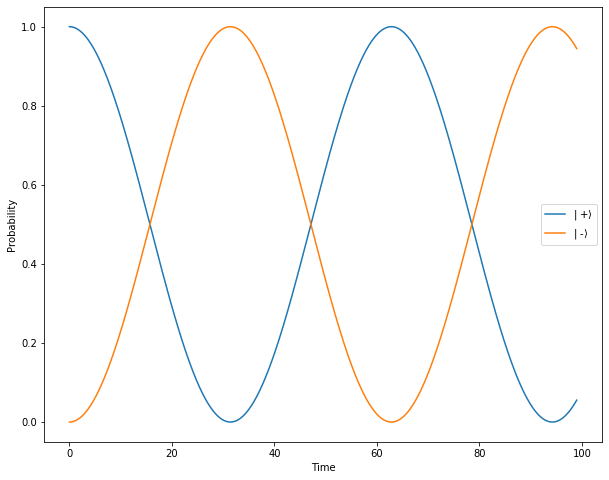

In [37]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("")
plt.show();

The Rabi frequency (and hence the difference in energy of the stationary states) is now given by $A$.

Now back to 2 TSS. If these are considered to be independent, then we should be able to work out the probabilities from above.

In [38]:
P2 = np.zeros([4,times.size], dtype="complex128")
P2[0,:] = P[0,:]*P[0,:]
P2[1,:] = P[0,:]*P[1,:]
P2[2,:] = P[1,:]*P[0,:]
P2[3,:] = P[1,:]*P[1,:]

In [40]:
bra_labels, ket_labels = make_braket_labels(mm_list)

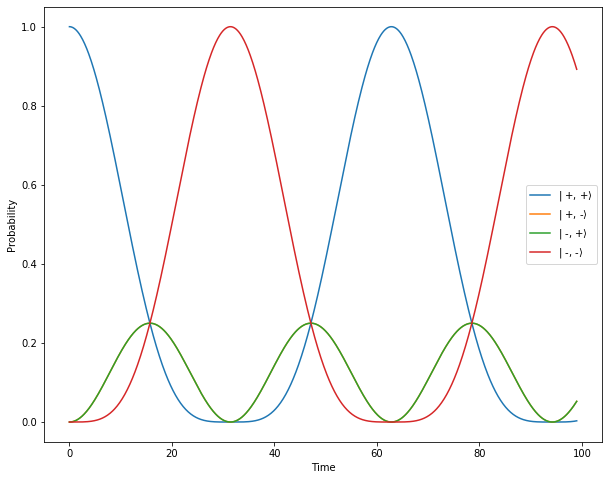

In [42]:
plt.figure(figsize=(10,8))
for i in range(0,P2.shape[0]):
    plt.plot(times, P2[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("")
plt.show();

What about the energies of the stationary states? We can have a guess by thinking that the energy difference of the levels being A. This means we can have ±A/2 for the levels. So we can have both upper giving A/2+A/2 = A, both lower giving -A or both opposite giving 0.

What about the stationary states themselves? We could probably work it out, but at this point it might be easier to try and figure out the Hamiltonian and calculate from there.

A natural starting point for the Hamiltonian of $N$  independent TSS is then


$$
H = - A \overset{N}{\underset{n=1}{\Sigma}} S_{n x}
$$

Because spin represents angular momentum, the combination of spin operators above is mathematically the same as how one would create the [total angular momentum operators](https://www2.ph.ed.ac.uk/~ldeldebb/docs/QM/lect15.pdf) - denoted by $J$, e.g. $Jx = \overset{N}{\underset{n=1}{\Sigma}} S_{n x}$. The Hamiltonian can then be written more compactly as:

$$
H = - A J_{x}
$$

Let's see if we can reproduce the above figure from this Hamiltonian.

QuTiP has a nice function to generate the J operators for any given number of TSS.

In [75]:
J = jspin(2, basis="uncoupled")


In [76]:
A=0.1
H = -A*J[0]

times = np.linspace(0.0, 99.0, 1000) 

psi0=basis(4,0)

P, psi = simulate(H, psi0, times)

In [77]:
bra_labels, ket_labels = make_braket_labels(mm_list)

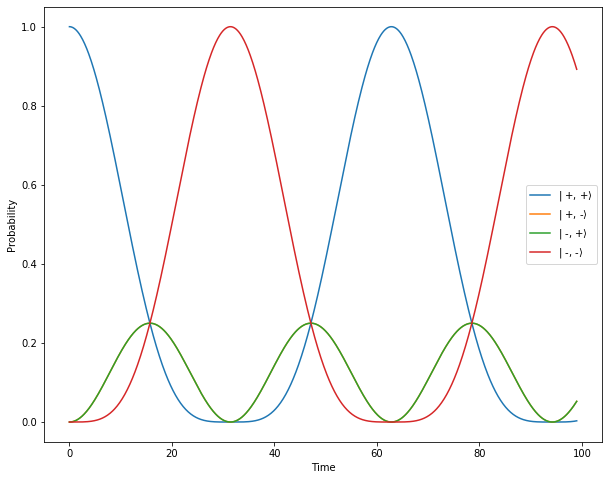

In [78]:
plt.figure(figsize=(10,8))
for i in range(0,P2.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("")
plt.show();

Great, that seemed to work! Let's take a look at the stationary states by calculating the eigenvalues and eigenstates

In [79]:
evals, ekets = H.eigenstates()

In [80]:
evals

array([-1.00000000e-01,  0.00000000e+00,  9.71445147e-17,  1.00000000e-01])

Exactly as we thought (ignore the tiny number - it's a numerical error)

In [81]:
prettify_states(ekets, mm_list)

,0,1,2,3
"(+, +)",0.5+0.0j,0.0+0.0j,0.7+0.0j,0.5+0.0j
"(+, -)",0.5+0.0j,0.7+0.0j,0.0+0.0j,-0.5+0.0j
"(-, +)",0.5+0.0j,-0.7+0.0j,0.0+0.0j,-0.5+0.0j
"(-, -)",0.5+0.0j,0.0+0.0j,-0.7+0.0j,0.5+0.0j


Although the stationary states look a bit complicated they are actually just combinations of the 2 stationary states from the single TSS, i.e.

- |+> + |->
- |+> - |->

For example, column 0 (the state corresponding to energy = -0.1) is made from:

$$(|+> + \ |->) \otimes (|+> + \ |->) = |+,+> +\ |+,-> + \ |-,+> + \ |-,->$$

What else can we learn from this system?

Just like in Tutorial 2, we can perturb the system and see what happens.


## Perturbing 2 TSS

We imagine some kind of perturbing field that affects all the TSS in the same way.

We can extend the Hamiltonian to include a perturbation $\delta$ in a similar way to above:

$$
H = - A J_{x} + \delta J_{z}
$$

where here $J_z = \overset{N}{\underset{n=1}{\Sigma}} S_{n z}$

We proceed as we have done several times by looking for the stationary states of the system. When the system is in one of these states it will remain there for all time. Such states are described by a single constant energy.


We'll calculate the eigenvalues of the Hamiltonian (i.e the energies) and see how they depend on the perturbation strength $\delta$. When we did this in Tutorial 2 we discovered an avoided crossing (aka anti-crossing) when the perturbation was zero - this was due to the coupling between the states splitting the energy levels apart.

Let's see what we find.

In [107]:
J = jspin(2, basis="uncoupled")

In [108]:
df = make_df_for_energy_scan("$\delta$/A", -4,4, 100, J[0].shape[0]) 

In [109]:
for i, row in df.iterrows():
    H = - A*J[0] + row[ "$\delta$/A"]*A*J[2]
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

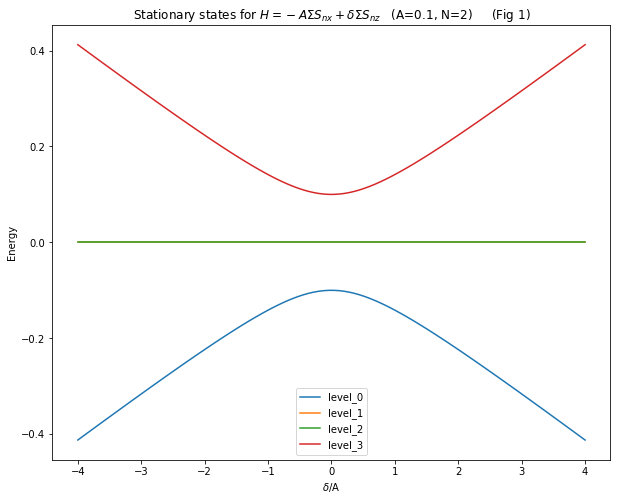

In [110]:
df.plot(x="$\delta$/A",figsize=(10,8),legend=True, 
        title="Stationary states for $H=-A\Sigma S_{nx} + \delta \Sigma S_{nz}$   (A=0.1, N=2)     (Fig 1)");
plt.ylabel("Energy");

> TODO: Comment on two degenerate levels and see what the eigenfunctions look like as a function of delta. Use this to motivate different universes that dont talk to each other

In [456]:
ekets

array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-0.01492875]
 [-0.12126781]
 [-0.12126781]
 [-0.98507125]],
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-0.17149859]
 [-0.68599434]
 [-0.68599434]
 [ 0.17149859]],
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.70710678]
 [-0.70710678]
 [ 0.        ]],
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.98507125]
 [-0.12126781]
 [-0.12126781]
 [ 0.01492875]]], dtype=object)

> TODO: link back to conservation of angular momentum and motivate J^2 operator

In [457]:
J2 = Jx**2 + Jy**2 + Jz**2

In [458]:
J2

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 2.]]

> TODO: See that J2 is indeed conserved by commutator with the last Hamiltonian we just calculated

In [459]:
commutator(H,J2)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

> TODO: Transform to basis of constant energy reveals level 3 has a different J^2 - this is why it cannot mix with the -- and ++ states which have J^2 of 2

In [27]:
J2.transform(ekets)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 2.]]

> TODO: Better to work in a basis of constant "angular momentum"

In [479]:
J = jspin(2)

In [480]:
J

[Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0.         0.70710678 0.         0.        ]
  [0.70710678 0.         0.70710678 0.        ]
  [0.         0.70710678 0.         0.        ]
  [0.         0.         0.         0.        ]],
 Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0.+0.j         0.-0.70710678j 0.+0.j         0.+0.j        ]
  [0.+0.70710678j 0.+0.j         0.-0.70710678j 0.+0.j        ]
  [0.+0.j         0.+0.70710678j 0.+0.j         0.+0.j        ]
  [0.+0.j         0.+0.j         0.+0.j         0.+0.j        ]],
 Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[ 1.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0. -1.  0.]
  [ 0.  0.  0.  0.]]]

In [481]:
Jx = J[0]
Jy = J[1]
Jz = J[2]

In [466]:
A = 0.01

In [467]:
H =  A*Jx

In [482]:
J2 = Jx**2 + Jy**2 + Jz**2

In [483]:
J2

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]]

> TOTO: moivate where j comes in and how it's related to j(j+1). QuTiP has functions for this stuff

In [491]:
N=100

j_vals(N)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])

In [493]:
m_vals(41)

array([-41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29,
       -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16,
       -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,
        -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
        11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
        24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
        37,  38,  39,  40,  41])

In [494]:
m_degeneracy(N,4)

47

In [495]:
def j_states_list(num_tss):
    i=0
    
    jm_list = []
    j_index = {}

    js = j_vals(num_tss)[::-1]
    
    for j in js:
        j_index[j] = []
        ms = m_vals(j)[::-1]
        for m in ms:
            j_index[j].append(i)
            jm_list.append((j,m))
            i+=1
    return j_index, jm_list

In [505]:
def make_braket_labels(jm_list):
    bra_labels = ["$\langle$"+str(Fraction(j))+", "+str(Fraction(m))+" |" for (j,m) in jm_list]
    ket_labels = ["| "+str(Fraction(j))+", "+str(Fraction(m))+"$\\rangle$" for (j,m) in jm_list]
    return bra_labels, ket_labels

In [178]:
def make_operators(num_tss, j):
    
    j_index, jm_list = j_states_list(num_tss)
    
    try:
        j_index[j]
    except:
        raise Exception(f"j needs to be one of {j_vals(num_tss)}")
    
    Js = jspin(num_tss)
    Jx = Js[0]
    Jz = Js[2]
    

    
    num_ms = len(m_vals(j))
    Jz = Jz.extract_states(j_index[j])
    Jx = Jx.extract_states(j_index[j])
    jm_list = [jm_list[i] for i in j_index[j]]
    
    
    
    return Jz, Jx, jm_list

In [543]:
Jz, Jx, jm_list = make_operators(6, 3)

In [544]:
df = make_df_for_energy_scan("$\Delta E$/A", -4,4, 100, Jz.shape[0])

In [545]:
A=0.1
for i, row in df.iterrows():
    H =  row[ "$\Delta E$/A"]*A*Jz +  A*Jx
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

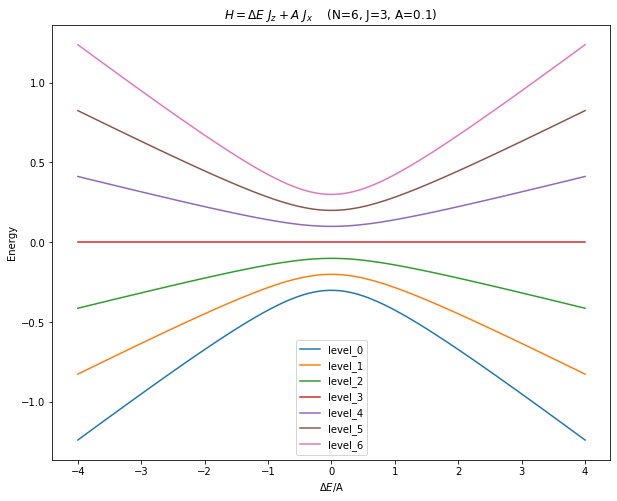

In [546]:
df.plot(x="$\Delta E$/A",figsize=(10,8),legend=True, 
        title="$H=\Delta E \ J_z + A \ J_x$    (N=6, J=3, A=0.1) ");
plt.ylabel("Energy");

In [169]:
bra_labels, ket_labels = make_braket_labels(jm_list)

In [353]:
delta = 0.001
A = 0.1

H0 = A*Jx

evals, estates = H0.eigenstates()

H1 =  delta*Jz

H = [H0,[H1,'cos(w*t)']]

times = np.linspace(0.0, 20000.0, 1000) 

#psi0=basis(4,0)
psi0 = estates[0]

result = sesolve(H, psi0, times, args={'w':A})

# result = sesolve(H0, basis(7,0), times)



In [354]:
num_states = result.states[0].shape[0]
psi = np.zeros([num_states,times.size], dtype="complex128")
P = np.zeros([num_states,times.size], dtype="complex128")

for i, state in enumerate(result.states):
    transformed_state = state.transform(estates)
    psi[:,i] = np.transpose(transformed_state)
    P[:,i] = np.abs(psi[:,i]*np.conj(psi[:,i]))

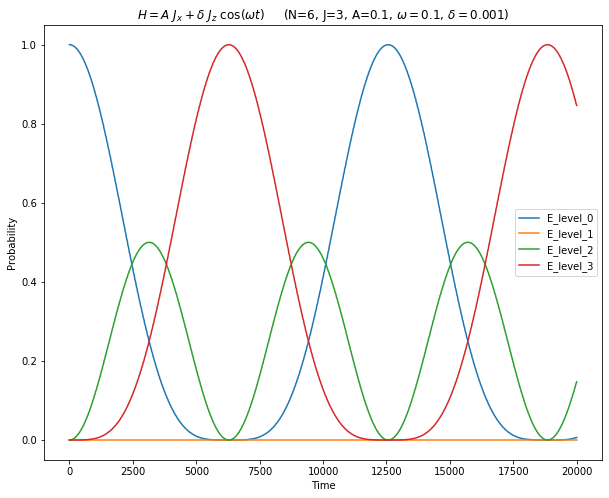

In [355]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"E_level_{i}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("$H =A \ J_x + \delta \ J_z \  \cos (\omega t)$     (N=6, J=3, A=0.1, $\omega = 0.1$, $\delta=0.001$)")
plt.show();

In [548]:
H0 = A*Jx

In [549]:
evals, estates = H0.eigenstates()

In [550]:
evals

array([-3.00000000e-01, -2.00000000e-01, -1.00000000e-01,  2.22044605e-16,
        1.00000000e-01,  2.00000000e-01,  3.00000000e-01])

In [551]:
estates

array([Quantum object: dims = [[7], [1]], shape = (7, 1), type = ket
Qobj data =
[[ 0.125     ]
 [-0.30618622]
 [ 0.48412292]
 [-0.55901699]
 [ 0.48412292]
 [-0.30618622]
 [ 0.125     ]],
       Quantum object: dims = [[7], [1]], shape = (7, 1), type = ket
Qobj data =
[[-0.30618622]
 [ 0.5       ]
 [-0.39528471]
 [ 0.        ]
 [ 0.39528471]
 [-0.5       ]
 [ 0.30618622]],
       Quantum object: dims = [[7], [1]], shape = (7, 1), type = ket
Qobj data =
[[ 0.48412292]
 [-0.39528471]
 [-0.125     ]
 [ 0.4330127 ]
 [-0.125     ]
 [-0.39528471]
 [ 0.48412292]],
       Quantum object: dims = [[7], [1]], shape = (7, 1), type = ket
Qobj data =
[[-0.55901699]
 [ 0.        ]
 [ 0.4330127 ]
 [ 0.        ]
 [-0.4330127 ]
 [ 0.        ]
 [ 0.55901699]],
       Quantum object: dims = [[7], [1]], shape = (7, 1), type = ket
Qobj data =
[[ 0.48412292]
 [ 0.39528471]
 [-0.125     ]
 [-0.4330127 ]
 [-0.125     ]
 [ 0.39528471]
 [ 0.48412292]],
       Quantum object: dims = [[7], [1]], shape = (7, 1), ty

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18266ea908>)

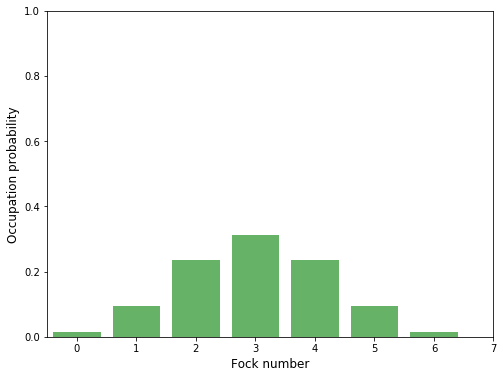

In [554]:
plot_fock_distribution(estates[6])

In [273]:
jm_list

[(3.0, 3.0),
 (3.0, 2.0),
 (3.0, 1.0),
 (3.0, 0.0),
 (3.0, -1.0),
 (3.0, -2.0),
 (3.0, -3.0)]

[Wolfram alpha eigenvalues](https://www.wolframalpha.com/input/?i=%7B%7B1%2Ca%2C0%7D%2C%7Ba%2C0%2Ca%7D%2C%7B0%2Ca%2C-1%7D%7D+eigenvalues)



In [176]:
"#' + '.join(x))
#             x.append(f"{val[0,0]:.2f}" + '|'+','.join(mm_list[j])+'>')"

SyntaxError: EOL while scanning string literal (<ipython-input-176-647971f197cd>, line 1)